# Run case in VN

In [348]:
!pip install pyro-ppl

In [349]:
from datetime import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
from pyro.contrib.epidemiology import CompartmentalModel, binomial_dist, infection_dist

%matplotlib inline
assert pyro.__version__.startswith('1.7.0')
torch.set_default_dtype(torch.double)  # Required for MCMC inference.
smoke_test = ('CI' in os.environ)

In [369]:
class SimpleSIRModel(CompartmentalModel):
    def __init__(self, population, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        self.data = data

    def global_model(self):
        tau = pyro.sample("tau", dist.LogNormal(2.6, 0.2)) 
        R0 = pyro.sample("R0", dist.LogNormal(1.1, 0.2))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        R0, tau, rho = params

        # Sample flows between compartments.
        S2I = pyro.sample("S2I_{}".format(t),
                          infection_dist(individual_rate=R0 / tau,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau))

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)


In [370]:
population = 96484000
data = pd.read_csv('https://vnexpress.net/microservice/sheet/type/covid19_2021_by_day')
data['date'] = pd.to_datetime(data['NGÀY'], format='%d/%m').apply(lambda dt: dt.replace(year=2021))
data = data[data['date'] <= datetime.now()]
data = data[['date','new_deaths','new_recovered','new_cases']]
data = data.fillna(0)
data = data.set_index('date')
data = data[(data.index <= '2021-08-27' )]

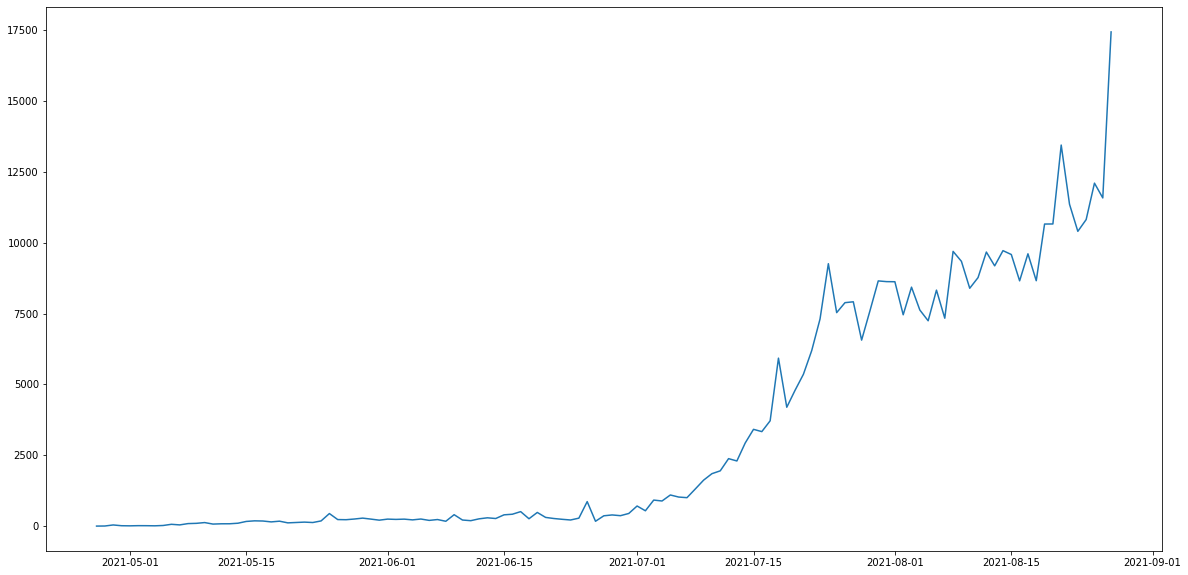

In [371]:
plt.figure(figsize=(20, 10))
plt.plot(data.index,data['new_cases'])

In [372]:
data = data['new_cases']

In [373]:
model = SimpleSIRModel(population, torch.Tensor(data))

In [374]:
model.fit_mcmc(num_samples=600,jit_compile=True)


INFO:pyro.contrib.epidemiology.compartmental:Running inference...
Sample: 100%|██████████| 1200/1200 [01:23, 14.32it/s, step size=2.62e-04, acc. prob=0.850]


In [375]:
covid_parameters = {}

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `dis

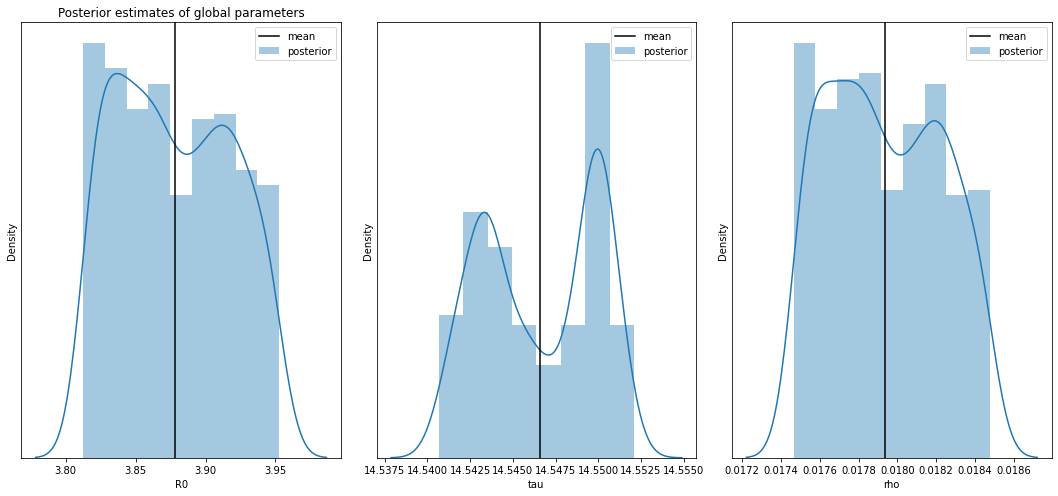

In [376]:
samples = model.predict()

names = ["R0", 'tau', 'rho']
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    covid_parameters[name] = samples[name].mean()
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(covid_parameters[name], color="k", label="mean")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
    
plt.tight_layout()

In [367]:
covid_parameters

{'R0': tensor(22.2086), 'rho': tensor(0.0015), 'tau': tensor(13.9598)}

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
INFO:pyro.contrib.epidemiology.compartmental:Forecasting 10 steps ahead...


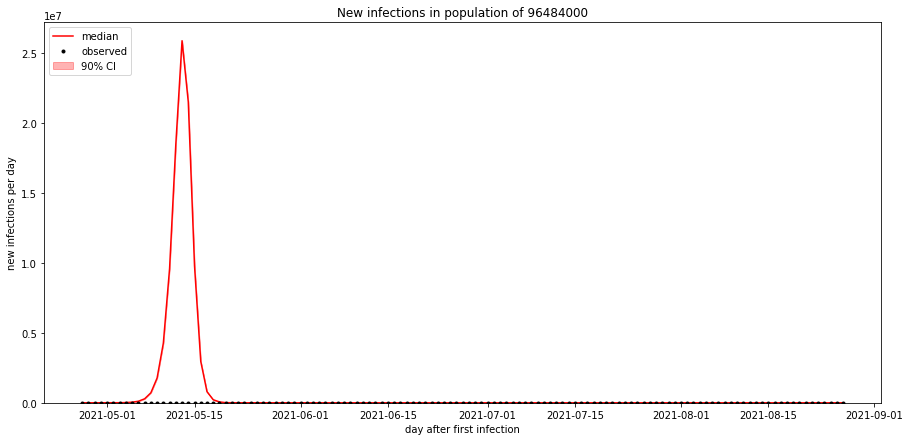

In [368]:
samples = model.predict(forecast=10)

def plot_forecast(samples, data):
    duration = len(data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])
    
    time = list(data.index.values) + [data.index.values[-1] + (i+1) for i in range(forecast)]
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    _, ax = plt.subplots(1,1,figsize=(15, 7))
    
    ax.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    ax.plot(time, median, "r-", label="median")
    ax.plot(time[:duration], data.values, "k.", label="observed")
    ax.set_ylim(0, None)
    ax.set_xlabel("day after first infection")
    ax.set_ylabel("new infections per day")
    ax.set_title("New infections in population of {}".format(population))
    ax.legend(loc="upper left")
    

plot_forecast(samples, data)

In [ ]:
class HeterogeneousSIRModel(CompartmentalModel):
    def __init__(self, population, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        self.data = data

    def global_model(self):
        tau = pyro.sample("tau", dist.LogNormal(3.0, 0.1)) 
        R0 = pyro.sample("R0", dist.LogNormal(0.5, 0.1))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau, rho

    def initialize(self, params):
        # Start with a single infection.
        # We also store the initial beta value in the state dict.
        return {"S": self.population - 1, "I": 1, "beta": torch.tensor(1.)}

    def transition(self, params, state, t):
        R0, tau, rho = params
        # Sample heterogeneous variables.
        # This assumes beta slowly drifts via Brownian motion in log space.
        beta = pyro.sample(
            "beta_{}".format(t), dist.LogNormal(state["beta"].log(), 0.1)
        )
        Rt = pyro.deterministic("Rt_{}".format(t), R0 * beta)

        # Sample flows between compartments.
        S2I = pyro.sample(
            "S2I_{}".format(t),
            infection_dist(
                individual_rate=Rt / tau,
                num_susceptible=state["S"],
                num_infectious=state["I"],
                population=self.population,
            ),
        )
        I2R = pyro.sample("I2R_{}".format(t), binomial_dist(state["I"], 1 / tau))

        # Update compartments and heterogeneous variables.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R
        state["beta"] = beta  # We store the latest beta value in the state dict.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_{}".format(t),
                    binomial_dist(S2I, rho),
                    obs=self.data[t] if t_is_observed else None)

In [ ]:
population = 96484000
data = pd.read_csv('https://vnexpress.net/microservice/sheet/type/covid19_2021_by_day')
data['date'] = pd.to_datetime(data['NGÀY'], format='%d/%m').apply(lambda dt: dt.replace(year=2021))
data = data[data['date'] <= datetime.now()]
data = data[['date','new_deaths','new_recovered','new_cases']]
data = data.fillna(0)
data = data.set_index('date')
data = data[(data.index <= '2021-08-27' )& (data.index >= '2021-06-20')]

In [ ]:
data = data['new_cases']

In [ ]:
model = HeterogeneousSIRModel(population, torch.Tensor(data))

In [ ]:
model.fit_mcmc(num_samples=400, jit_compile=True)

INFO:pyro.contrib.epidemiology.compartmental:Running inference...
Sample: 100%|██████████| 800/800 [01:07, 11.86it/s, step size=9.20e-03, acc. prob=0.863]


INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 69 time steps...
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `disp

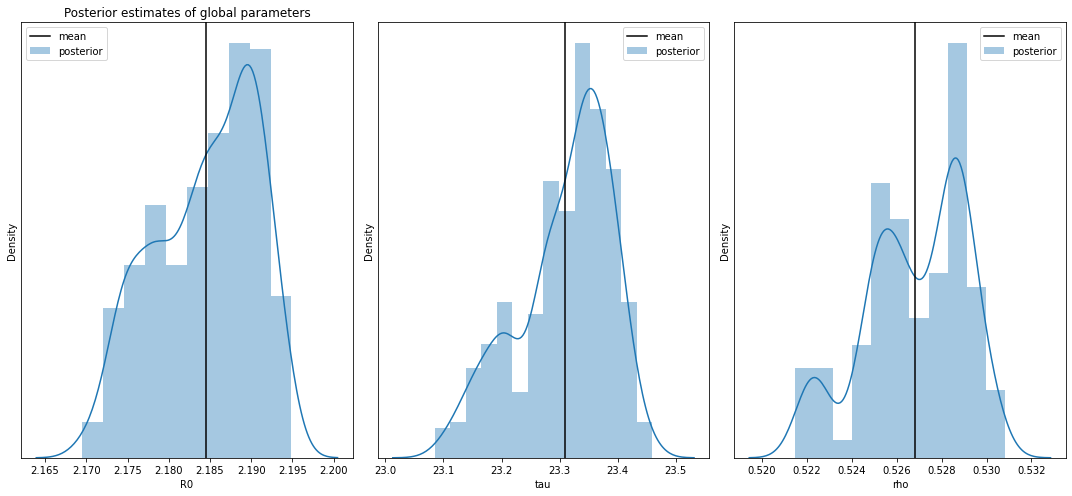

In [ ]:
covid_parameters = {}

samples = model.predict()

names = ["R0", 'tau', 'rho']
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    covid_parameters[name] = samples[name].mean()
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(covid_parameters[name], color="k", label="mean")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
    
plt.tight_layout()

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
INFO:pyro.contrib.epidemiology.compartmental:Forecasting 30 steps ahead...


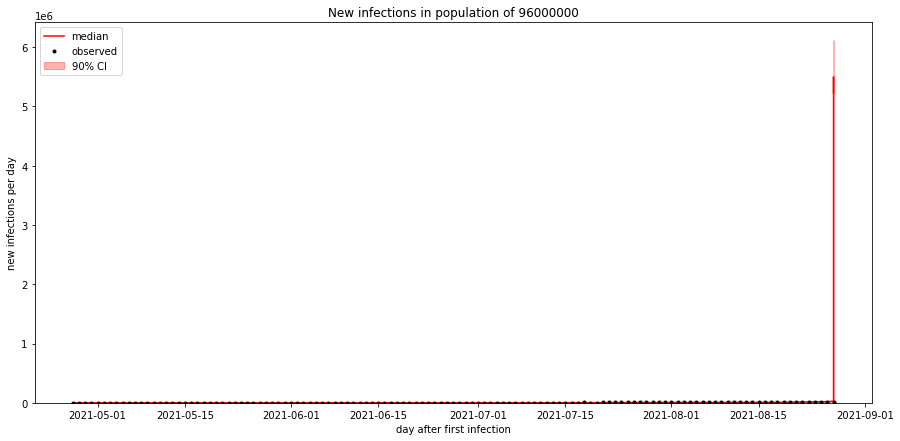

In [ ]:
samples = model.predict(forecast=30)

def plot_forecast(samples, data):
    duration = len(data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])
    
    time = list(data.index.values) + [data.index.values[-1] + (i+1) for i in range(forecast)]
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    _, ax = plt.subplots(1,1,figsize=(15, 7))
    
    ax.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    ax.plot(time, median, "r-", label="median")
    ax.plot(time[:duration], data.values, "k.", label="observed")
    ax.set_ylim(0, None)
    ax.set_xlabel("day after first infection")
    ax.set_ylabel("new infections per day")
    ax.set_title("New infections in population of {}".format(population))
    ax.legend(loc="upper left")
    

plot_forecast(samples, data)

In [ ]:
model.fit_svi(num_samples=400)

INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...
INFO 	 Failed to find feasible hypothesis after site obs_0. Retrying...


SMCFailed: ignored

In [ ]:
class OverdispersedSIRModel(CompartmentalModel):
    """
    Generalizes :class:`SimpleSIRModel` with overdispersed distributions.

    To customize this model we recommend forking and editing this class.

    This adds a single global overdispersion parameter controlling
    overdispersion of the transition and observation distributions. See
    :func:`~pyro.contrib.epidemiology.distributions.binomial_dist` and
    :func:`~pyro.contrib.epidemiology.distributions.beta_binomial_dist` for
    distributional details. For prior work incorporating overdispersed
    distributions see [1,2,3,4].

    **References:**

    [1] D. Champredon, M. Li, B. Bolker. J. Dushoff (2018)
        "Two approaches to forecast Ebola synthetic epidemics"
        https://www.sciencedirect.com/science/article/pii/S1755436517300233
    [2] Carrie Reed et al. (2015)
        "Estimating Influenza Disease Burden from Population-Based Surveillance
        Data in the United States"
        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349859/
    [3] A. Leonard, D. Weissman, B. Greenbaum, E. Ghedin, K. Koelle (2017)
        "Transmission Bottleneck Size Estimation from Pathogen Deep-Sequencing
        Data, with an Application to Human Influenza A Virus"
        https://jvi.asm.org/content/jvi/91/14/e00171-17.full.pdf
    [4] A. Miller, N. Foti, J. Lewnard, N. Jewell, C. Guestrin, E. Fox (2020)
        "Mobility trends provide a leading indicator of changes in
        SARS-CoV-2 transmission"
        https://www.medrxiv.org/content/medrxiv/early/2020/05/11/2020.05.07.20094441.full.pdf

    :param int population: Total ``population = S + I + R``.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> I``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, data):
        compartments = ("S", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        self.data = data

    def global_model(self):
        tau = pyro.sample("tau", dist.LogNormal(3., 0.1)) 
        R0 = pyro.sample("R0", dist.LogNormal(0.0, 1.0))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        od = pyro.sample("od", dist.Beta(2, 6))
        return R0, tau, rho, od

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "I": 1}

    def transition(self, params, state, t):
        R0, tau, rho, od = params

        # Sample flows between compartments.
        S2I = pyro.sample(
            "S2I_{}".format(t),
            infection_dist(
                individual_rate=R0 / tau,
                num_susceptible=state["S"],
                num_infectious=state["I"],
                population=self.population,
                overdispersion=od,
            ),
        )
        I2R = pyro.sample(
            "I2R_{}".format(t), binomial_dist(state["I"], 1 / tau, overdispersion=od)
        )

        # Update compartments with flows.
        state["S"] = state["S"] - S2I
        state["I"] = state["I"] + S2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample(
            "obs_{}".format(t),
            binomial_dist(S2I, rho, overdispersion=od),
            obs=self.data[t] if t_is_observed else None,
        )

In [ ]:
model = OverdispersedSIRModel(population, torch.Tensor(data))
model.fit_mcmc(num_samples=400, jit_compile=True)

INFO:pyro.contrib.epidemiology.compartmental:Running inference...
Sample: 100%|██████████| 800/800 [01:37,  8.22it/s, step size=1.41e-02, acc. prob=0.942]


INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 69 time steps...
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `disp

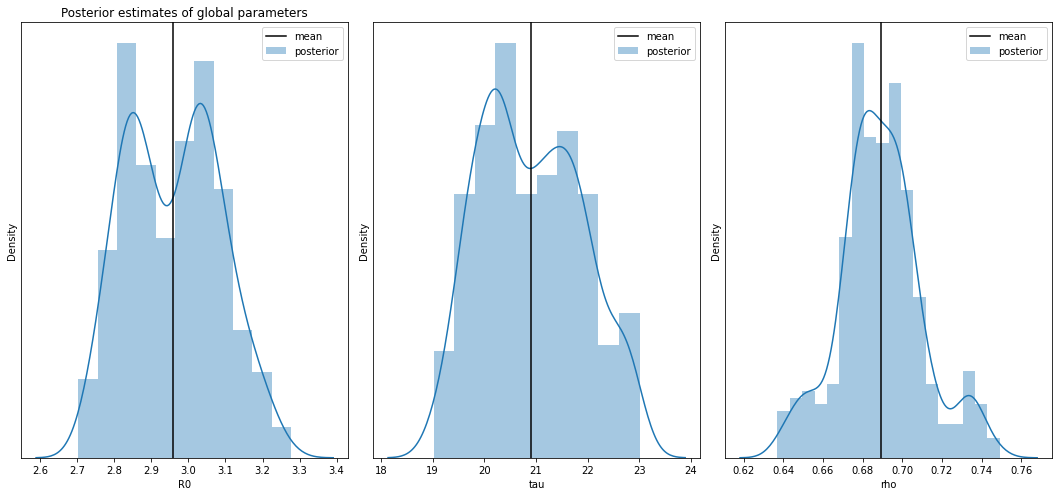

In [ ]:
covid_parameters = {}

samples = model.predict()

names = ["R0", 'tau', 'rho']
fig, axes = plt.subplots(1, 3, figsize=(15, 7))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    covid_parameters[name] = samples[name].mean()
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(covid_parameters[name], color="k", label="mean")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
    
plt.tight_layout()

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 69 time steps...
INFO:pyro.contrib.epidemiology.compartmental:Forecasting 10 steps ahead...


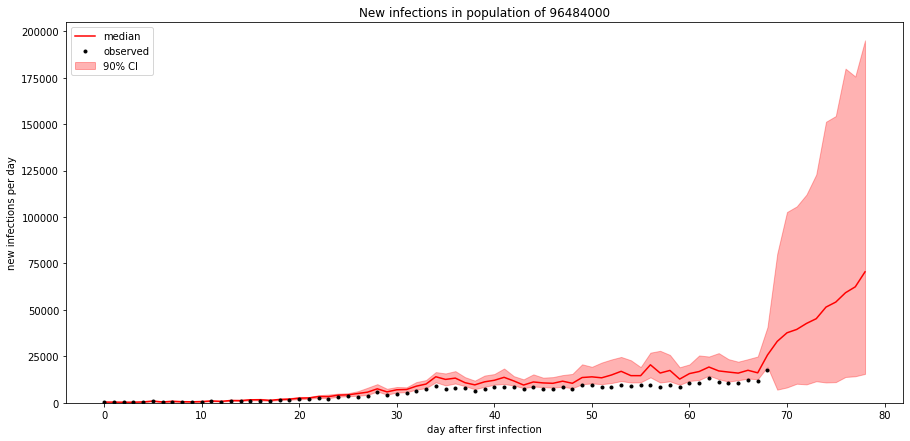

In [ ]:
samples = model.predict(forecast=10)

def plot_forecast(samples, data):
    duration = len(data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])
    
    time = list(data.index.values) + [data.index.values[-1] + (i+1) for i in range(forecast)]
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    _, ax = plt.subplots(1,1,figsize=(15, 7))
    
    ax.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    ax.plot(time, median, "r-", label="median")
    ax.plot(time[:duration], data.values, "k.", label="observed")
    ax.set_ylim(0, None)
    ax.set_xlabel("day after first infection")
    ax.set_ylabel("new infections per day")
    ax.set_title("New infections in population of {}".format(population))
    ax.legend(loc="upper left")
    

plot_forecast(samples, data)

## II. The SEIR model:

When no vaccine is available, the isolation of diagnosed infectives and social distancing are the only control measures available. We consider an SEIR epidemic disease model. The total (initial) population, N0, is categorized into four classes, namely, susceptible, S(t), exposed, E(t), infected-infectious, I(t) and recovered, R(t), where t is the time variable. The governing differential equations are

$$
\begin{array}{rcr} 
\frac{dS}{dt} & = & -\beta S\frac{I}{N} \\ 
\frac{dE}{dt} & = & \beta S\frac{I}{N} - \sigma E \\
\frac{dI}{dt} & = & \sigma E - \gamma I \\
\frac{dR}{dt} & = & \gamma I
\end{array}
$$

$\beta, \sigma, \gamma$ denote the infection rate, onset rate, and removal rate. Where N = S + E + I + R ≤ N0 in this case, and a dot above a variable denotes time differentiation

$R_0 = \frac{\beta}{\gamma}$ will be the basic reproduction ratio, which is the average number of people an Infected can transfer the disease to.  
$\tau_{incubation} = \frac{1}{\sigma}$ will be the incubation period, which is the time a subject changes from contacted with an Infected to became Infected.  
$\tau_{recoverd} = \frac{1}{\gamma}$ will be the removal period, which is the time a subject changes from infected to removal (recovered or dead)

We are interested in $\theta = (R_0, \tau_{incubation}, \tau_{recoverd})$.

Follow the report of WHO on Covid-19, we will setup the priors of $R_0, \tau_{incubation}, \tau_{recoverd}$ with means equal to 3.2 basic reproduction ratio, 14 days incubation, and 28 days recovery respectively.


In [ ]:
class SimpleSEIRModel(CompartmentalModel):
    def __init__(self, population, case, remove):
        compartments = ("S", "E", "I")  # R is implicit.
        super().__init__(compartments, len(case), population)        
        self.case = case
        self.remove = remove

    def global_model(self):
        tau_e = pyro.sample("tau_e", dist.Normal(14., 5)) # incubation_time
        tau_i= pyro.sample("tau_i", dist.Normal(20, 5))  # recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(1.1, 0.1))
        rho = pyro.sample("rho", dist.Beta(100, 100))
        return R0, tau_i, tau_e, rho

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}
    
    def transition(self, params, state, t):
        R0, tau_i, tau_e, rho = params

        # Sample flows between compartments.
        S2E = pyro.sample("S2E_{}".format(t),
                          infection_dist(individual_rate=R0 / tau_e,
                                         num_susceptible=state["S"],
                                         num_infectious=state["I"],
                                         population=self.population))
        E2I = pyro.sample("E2I_{}".format(t),
                          binomial_dist(state["E"], 1 / tau_i))
        I2R = pyro.sample("I2R_{}".format(t),
                          binomial_dist(state["I"], 1 / tau_e))

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample("obs_nc_{}".format(t),
                    binomial_dist(E2I, rho),
                    obs=self.case[t] if t_is_observed else None)

In [ ]:
population = 96000000
data = pd.read_csv('https://vnexpress.net/microservice/sheet/type/covid19_2021_by_day')
data['date'] = pd.to_datetime(data['NGÀY'], format='%d/%m').apply(lambda dt: dt.replace(year=2021))
data = data[data['date'] <= datetime.now()]
data = data[['date','new_deaths','new_recovered','new_cases']]
data = data.fillna(0)
data = data.set_index('date')
data = data[(data.index <= '2021-08-27' )]
case = data['new_cases'].reset_index(drop=True)
remove = data['new_recovered'].reset_index(drop=True)

In [ ]:
model = SimpleSEIRModel(population, torch.Tensor(case),torch.Tensor(remove))
model.fit_mcmc(num_samples=400, jit_compile=True)

INFO:pyro.contrib.epidemiology.compartmental:Running inference...
Sample: 100%|██████████| 800/800 [01:02, 12.82it/s, step size=5.42e-04, acc. prob=0.787]


INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `dis

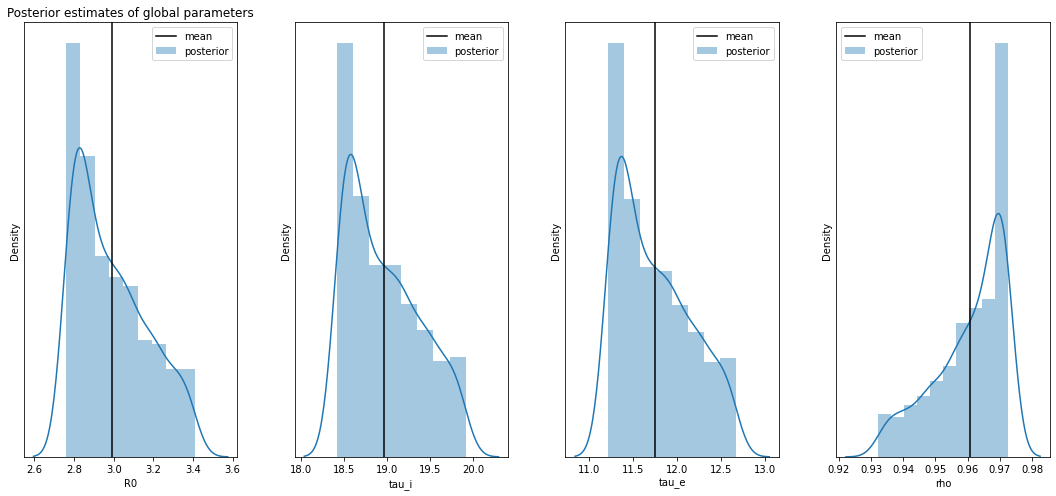

In [ ]:
covid_parameters = {}

samples = model.predict()

names = ["R0", "tau_i", 'tau_e', 'rho']
fig, axes = plt.subplots(1, 4, figsize=(15, 7))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    covid_parameters[name] = samples[name].mean()
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(covid_parameters[name], color="k", label="mean")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
    
plt.tight_layout()

In [ ]:
covid_parameters

{'R0': tensor(2.9895),
 'rho': tensor(0.9607),
 'tau_e': tensor(11.7468),
 'tau_i': tensor(18.9650)}

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
INFO:pyro.contrib.epidemiology.compartmental:Forecasting 30 steps ahead...


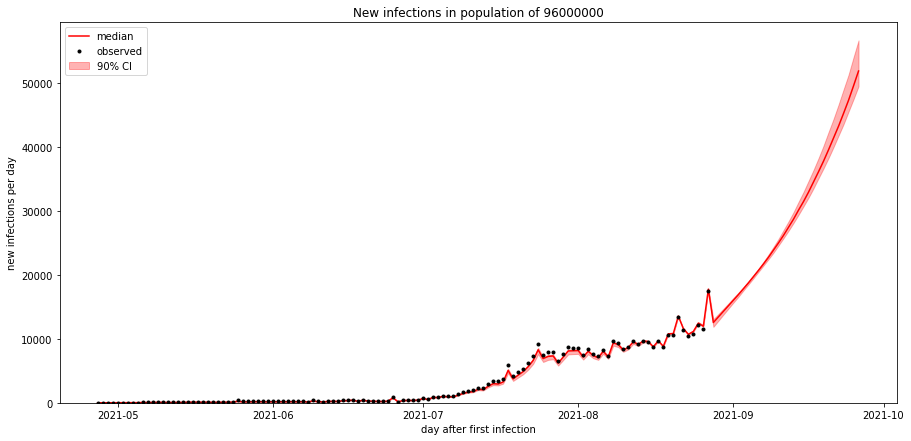

In [ ]:
samples = model.predict(forecast=30)

def plot_forecast(samples, data):
    duration = len(data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])
    
    time = list(data.index.values) + [data.index.values[-1] + np.timedelta64(i+1,'D') for i in range(forecast)]
    S2I = samples["E2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    _, ax = plt.subplots(1,1,figsize=(15, 7))
    
    ax.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    ax.plot(time, median, "r-", label="median")
    ax.plot(time[:duration], data['new_cases'].values, "k.", label="observed")
    ax.set_ylim(0, None)
    ax.set_xlabel("day after first infection")
    ax.set_ylabel("new infections per day")
    ax.set_title("New infections in population of {}".format(population))
    ax.legend(loc="upper left")
    

plot_forecast(samples, data)

In [ ]:
class OverdispersedSEIRModel(CompartmentalModel):
    """
    Generalizes :class:`SimpleSEIRModel` with overdispersed distributions.

    To customize this model we recommend forking and editing this class.

    This adds a single global overdispersion parameter controlling
    overdispersion of the transition and observation distributions. See
    :func:`~pyro.contrib.epidemiology.distributions.binomial_dist` and
    :func:`~pyro.contrib.epidemiology.distributions.beta_binomial_dist` for
    distributional details. For prior work incorporating overdispersed
    distributions see [1,2,3,4].

    **References:**

    [1] D. Champredon, M. Li, B. Bolker. J. Dushoff (2018)
        "Two approaches to forecast Ebola synthetic epidemics"
        https://www.sciencedirect.com/science/article/pii/S1755436517300233
    [2] Carrie Reed et al. (2015)
        "Estimating Influenza Disease Burden from Population-Based Surveillance
        Data in the United States"
        https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349859/
    [3] A. Leonard, D. Weissman, B. Greenbaum, E. Ghedin, K. Koelle (2017)
        "Transmission Bottleneck Size Estimation from Pathogen Deep-Sequencing
        Data, with an Application to Human Influenza A Virus"
        https://jvi.asm.org/content/jvi/91/14/e00171-17.full.pdf
    [4] A. Miller, N. Foti, J. Lewnard, N. Jewell, C. Guestrin, E. Fox (2020)
        "Mobility trends provide a leading indicator of changes in
        SARS-CoV-2 transmission"
        https://www.medrxiv.org/content/medrxiv/early/2020/05/11/2020.05.07.20094441.full.pdf

    :param int population: Total ``population = S + E + I + R``.
    :param float incubation_time: Mean incubation time (duration in state
        ``E``). Must be greater than 1.
    :param float recovery_time: Mean recovery time (duration in state
        ``I``). Must be greater than 1.
    :param iterable data: Time series of new observed infections. Each time
        step is Binomial distributed between 0 and the number of ``S -> E``
        transitions. This allows false negative but no false positives.
    """

    def __init__(self, population, incubation_time,data):
        compartments = ("S", "E", "I")  # R is implicit.
        duration = len(data)
        super().__init__(compartments, duration, population)
        self.data = data

    def global_model(self):
        tau_e = pyro.sample("tau_e", dist.Normal(10., 5)) # incubation_time
        tau_i= pyro.sample("tau_i", dist.Normal(20., 5))  # recovery_time
        R0 = pyro.sample("R0", dist.LogNormal(1.1, 0.1))
        rho = pyro.sample("rho", dist.Beta(10, 10))
        od = pyro.sample("od", dist.Beta(2, 6))
        return R0, tau_e, tau_i, rho, od

    def initialize(self, params):
        # Start with a single infection.
        return {"S": self.population - 1, "E": 0, "I": 1}

    def transition(self, params, state, t):
        R0, tau_e, tau_i, rho, od = params

        # Sample flows between compartments.
        S2E = pyro.sample(
            "S2E_{}".format(t),
            infection_dist(
                individual_rate=R0 / tau_i,
                num_susceptible=state["S"],
                num_infectious=state["I"],
                population=self.population,
                overdispersion=od,
            ),
        )
        E2I = pyro.sample(
            "E2I_{}".format(t), binomial_dist(state["E"], 1 / tau_e, overdispersion=od)
        )
        I2R = pyro.sample(
            "I2R_{}".format(t), binomial_dist(state["I"], 1 / tau_i, overdispersion=od)
        )

        # Update compartments with flows.
        state["S"] = state["S"] - S2E
        state["E"] = state["E"] + S2E - E2I
        state["I"] = state["I"] + E2I - I2R

        # Condition on observations.
        t_is_observed = isinstance(t, slice) or t < self.duration
        pyro.sample(
            "obs_{}".format(t),
            binomial_dist(S2E, rho, overdispersion=od),
            obs=self.data[t] if t_is_observed else None,
        )

In [ ]:
model = OverdispersedSEIRModel(population, torch.Tensor(case),torch.Tensor(remove))
model.fit_mcmc(num_samples=400, jit_compile=True)

INFO:pyro.contrib.epidemiology.compartmental:Running inference...
Sample: 100%|██████████| 800/800 [01:36,  8.28it/s, step size=1.67e-02, acc. prob=0.849]


INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `dis

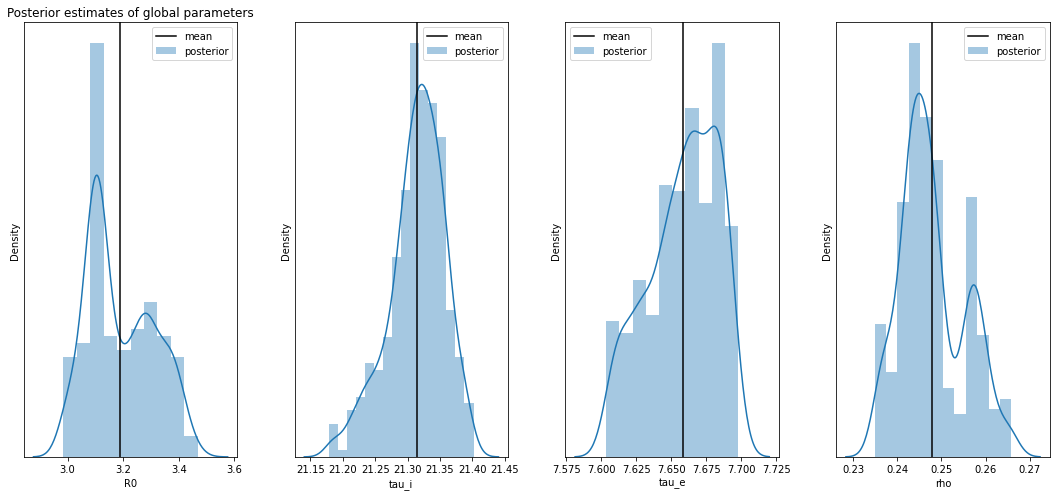

In [ ]:
covid_parameters = {}

samples = model.predict()

names = ["R0", "tau_i", 'tau_e', 'rho']
fig, axes = plt.subplots(1, 4, figsize=(15, 7))
axes[0].set_title("Posterior estimates of global parameters")
for ax, name in zip(axes, names):
    covid_parameters[name] = samples[name].mean()
    sns.distplot(samples[name], ax=ax, label="posterior")
    ax.axvline(covid_parameters[name], color="k", label="mean")
    ax.set_xlabel(name)
    ax.set_yticks(())
    ax.legend(loc="best")
    
plt.tight_layout()

In [ ]:
covid_parameters

{'R0': tensor(3.1891),
 'rho': tensor(0.2480),
 'tau_e': tensor(7.6585),
 'tau_i': tensor(21.3144)}

INFO:pyro.contrib.epidemiology.compartmental:Predicting latent variables for 123 time steps...
INFO:pyro.contrib.epidemiology.compartmental:Forecasting 30 steps ahead...


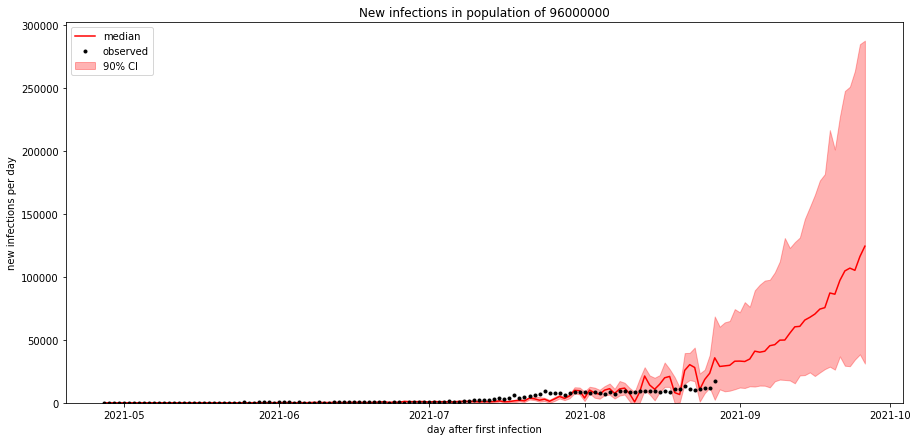

In [ ]:
samples = model.predict(forecast=30)

def plot_forecast(samples, data):
    duration = len(data)
    forecast = samples["S"].size(-1) - duration
    num_samples = len(samples["R0"])
    
    time = list(data.index.values) + [data.index.values[-1] + np.timedelta64(i+1,'D') for i in range(forecast)]
    S2I = samples["E2I"]
    median = S2I.median(dim=0).values
    p05 = S2I.kthvalue(int(round(0.5 + 0.05 * num_samples)), dim=0).values
    p95 = S2I.kthvalue(int(round(0.5 + 0.95 * num_samples)), dim=0).values

    _, ax = plt.subplots(1,1,figsize=(15, 7))
    
    ax.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
    ax.plot(time, median, "r-", label="median")
    ax.plot(time[:duration], data['new_cases'].values, "k.", label="observed")
    ax.set_ylim(0, None)
    ax.set_xlabel("day after first infection")
    ax.set_ylabel("new infections per day")
    ax.set_title("New infections in population of {}".format(population))
    ax.legend(loc="upper left")
    

plot_forecast(samples, data)

## IV. Result Intepretation:

The results of model simple SEIR $R_0, \tau_{incubation}, \tau_{recovery}$ shows:  

- $R_0$ is more than 3.18 
- $\tau_{incubation}$ is 12 days  
- $\tau_{recovery}$ is 18 days

and the results of OverdispersedSEIRModel are:
- $R_0$ is more than 3.18 
- $\tau_{incubation}$ is short, just less than 8 days  
- $\tau_{recovery}$ is long, 22 days

Comparing to WHO report, we can see the results of two models are better than. However, line fit of simple SEIR seem better than another.
The forecast also indicates at least in the next month, COVID-19 does not reach the peak yet.

##V. Discussion
We see that, the simple model SIR cannot fit for Vietnam's data when we forecast, the results always show high trend. That results do not make sense in reality. 
The SEIR model seems more reasonable in trend in forecast. 
For against COVID-19 planning, we think distance, wearing a mask, and pushing vaccination speed quickly should be implemented more rigorously 